In [1]:
###########################################################
###########################################################
###########################################################

## 自变量 挖矿节点 难度目标
## 因变量 出块时间

## 目标：找到一组合适的 PID 参数，使得每挖一个块，做一次难度调节
##      使得连续生成 1000 个块的方差较小
##      多组PID参数做比较 原始难度调整策略做比较

## 使用hash算法 sha1, 一共 160位，难度前导0最多159位

## 目标挖矿平均时间 60s， 记录每个新块的产生时间

## CPU: 2.3 GHz Intel Core i9, 8 - core, use muti-process to simulate the mining nodes

## the root hash of merkle tree is selected by random.

###########################################################
###########################################################
###########################################################

In [2]:
## Support Functions
import hashlib
def sha1(obj: str):
    return hashlib.sha1(str(obj).encode('utf-8')).hexdigest()

In [3]:
## Block
class Block:
    duration = 0
    
    def __init__(self, height, pre_hash, merkle, nouce, transactions):
        self.height = height
        self.pre_hash = pre_hash
        self.merkle = merkle
        self.nouce = nouce
        self.transactions = transactions

    def getHash(self):
        return sha1(self)
    
    def __repr__(self):
        return str(self.pre_hash) + str(self.height) + str(self.merkle) + str(self.nouce)
    
    def printJSON(self):
        # DFS or BFS
        print("Hash:", self.getHash(), "Height:", self.height, "Pre_Hash:", self.pre_hash, "Merkle Hash:", self.merkle, "nouce:", self.nouce)
        pass

In [4]:
## mine difficaulty
## 40 - 4 = 36
## hash value should smaller than DIFFICULTY
import math
# DIFFICULTY = 0x00000FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
DIFFICULTY = 0x0000600000000000000000000000000000000000

print('Mine DIFFICULTY:', math.log2(DIFFICULTY))
# len("00000FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF")
# 5000000000000000000000000000000000000000000
# 22300745198530623141535718272648361505980415

Mine DIFFICULTY: 142.58496250072116


In [5]:
import matplotlib.pyplot as plt
def visualization(blocks):
    x = range(len(blocks))
    y = [block.duration if block.duration < 400 else 400 for block in blocks]
    x_standard = range(len(blocks))
    y_standard = [1 for i in x_standard]
    plt.figure(figsize=(20,4)) 
    l1=plt.plot(x,y,'r--',label='Mining')
    l2=plt.plot(x_standard,y_standard,'g--',label='Standard')
    plt.plot(x,y,'ro-',x_standard,y_standard,'g+-')
    plt.xlabel("Height")
    plt.ylabel("Time(s)")
    plt.legend()
    plt.title("Time Analysis")

# visualization([{"duration": 12},{"duration": 40}])

In [6]:
## PID ajustment
## U(t) = Kp*error(t) + Ki*integration(error(t)) + Kd*(error(t) - error(t-1))
## Initialize kp = 1.5  Ki = 1 Kd = 1, more epochs to find the best coefficient
## target = 60s
## error(t) = 60s - real_time
## new_Diffculty = old_Diffculty + U(t)
## old_Difficulty = 5 means 00000 + FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

# kp = 1
# ki = 0.5
# kd = 0.1
# portion = 10000000000000000000000000000000000000000
kp = 0.005
ki = 0.0005
kd = 0.0005
# kd = 0.0005
difficulties = []
# kp = 0.5, ki = 0.2, kd = 0.1
# kp = 0.5, ki = 0.3, kd = 0.1
# kp = 0.5, ki = 0.4, kd = 0.1

def adjustmentDifficulty(old_Difficulty,height):
    old_Difficulty = math.log2(old_Difficulty)
#     ut = kp*errors[height] + ki*errors_sum + kd*(errors[height] - errors[height-1])#     ut = kp*errors[height] + ki*errors_sum + kd*(errors[height] - errors[height-1])
    ut = kp*errors[height] + kd*(errors[height] - errors[height-1])#     ut = kp*errors[height] + ki*errors_sum + kd*(errors[height] - errors[height-1])
    new_Difficulty = old_Difficulty - ut
    difficulties.append(new_Difficulty)
#     print('********************************************************')
#     print('New Difficulty: ', new_Difficulty, 'Difficulty cahnge: ', ut)
    print('Difficulties: ', difficulties)
    print('********************************************************')
    return math.pow(2,  new_Difficulty)  

# def adjustmentDifficulty2(old_Difficulty,height):
#     ut = kp*portion*errors[height] + ki*portion*errors_sum + kd*portion*(errors[height] - errors[height-1])
#     new_Difficulty = old_Difficulty - ut
#     print('********************************************************')
#     print('New Difficulty: ', new_Difficulty, 'Difficulty cahnge: ', ut, ' errors: ', errors[height], ' errors_sum: ', errors_sum)
#     print('********************************************************')
#     difficulties.append(new_Difficulty)
#     return new_Difficulty

# print(adjustmentDifficulty(DIFFICULTY, 1))
    

In [7]:
## Start mining
import random
import sys
import os
from datetime import datetime
from multiprocessing import Process, Pool, Queue, Manager

epochs = 100
blocks = []
errors = [0]
errors_sum = 0
pre_hash = '0'
height = 1
max_nounce = sys.maxsize
one_hash_time = 2.7/1000000
actual_numbers = 100000
actual_unit_nounce = max_nounce // actual_numbers

# 100 blocks
nodes_numbers = [0,5,12,12,15,7,8,9,12,15,13,15,4,6,8,10,7,16,13,2,4,3,12,16,5,11,13,16,14,14,6,7,
                 5,12,12,15,7,8,9,12,15,13,15,4,6,8,10,7,16,13,2,4,3,12,16,5,11,13,16,14,14,6,7,
                 5,12,12,15,7,8,9,12,15,13,15,4,6,8,10,7,16,13,2,4,3,12,16,5,11,13,16,14,14,6,7,
                ]


def long_time_task(i, queue, start, height, pre_hash, merkle, DIFFICULTY):
#     print('Run task %s (%s)...' % (i, os.getpid()))
    start_time = datetime.now()
    while queue.empty():
#         print("process: %s nounce: %s" % (i, start))
        block = Block(height, pre_hash, merkle, start, [])
        if int(block.getHash(),16) < DIFFICULTY:
            block.printJSON()
            queue.put(start)
            break
        else:
            start += 1
    
while height < 1000:
    print('Epoch %s, Parent process %s, mining...' % (height, os.getpid()))
#     merkle = sha1(random.random())
    merkle = 'fc8a1f655608fd9506559af832554f111e13821c'
#     nodes_number = nodes_numbers[height]
    nodes_number = 16
    unit_nounce = max_nounce // nodes_number
    p = Pool()
    queue = Manager().Queue()
#     start_time = datetime.now()

    for i in range(nodes_number):
        start = i * unit_nounce # nounce
        p.apply_async(long_time_task, args = (i, queue, start, height, pre_hash, merkle, DIFFICULTY))  
    p.close()
    p.join()
    
#     end_time = datetime.now()
#     duration = end_time - start_time
#     duration = duration.total_seconds()
#     print('duration time: %s' % duration)
    
    result_nounce = queue.get(True)
    duration = (result_nounce % actual_unit_nounce) * one_hash_time
    
#     print('result_nounce:', result_nounce, 'actual_unit_nounce:', actual_unit_nounce)
#     print('duration: ', duration)
    
    block = Block(height, pre_hash, merkle, result_nounce, [])
    block.duration = duration
    blocks.append(block)
    error = 2 - duration
    errors.append(error)
    errors_sum += error
    
    print('errors', errors, "errors_sum", errors_sum)
    DIFFICULTY = adjustmentDifficulty(DIFFICULTY,height)

    height += 1
    pre_hash = block.getHash()

visualization(blocks)

Epoch 1, Parent process 51781, mining...
Hash: 000050ee0df28f3321a0525b357536eb2bac4519 Height: 1 Pre_Hash: 0 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8070450532247947950
errors [0, 1.769285] errors_sum 1.769285
Difficulties:  [142.57523143322115]
********************************************************
Epoch 2, Parent process 51781, mining...
Hash: 0000592ccd97f1e82a886fc22fa23e1e88d7eb7c Height: 2 Pre_Hash: 000050ee0df28f3321a0525b357536eb2bac4519 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517119033
errors [0, 1.769285, 1.9317359] errors_sum 3.7010209
Difficulties:  [142.57523143322115, 142.56549152827114]
********************************************************
Epoch 3, Parent process 51781, mining...
Hash: 00001c76c2dabaac9a5f0584eb72383431b8e41a Height: 3 Pre_Hash: 0000592ccd97f1e82a886fc22fa23e1e88d7eb7c Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266123977046
errors [0, 1.769285, 1.9317359, 1.8763508] errors

Hash: 00003706136514cf687521fdc403ffa1e1e26e65 Height: 16 Pre_Hash: 00001d217ef7539be5293a6117a30b37da264be2 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427401776
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048] errors_sum 30.028019899999997
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.48082068702115, 142.47120282747116, 142.46241839717115, 142.45259197612114, 142.44317918967113, 142.43389229882112]
********************************************************
Epoch 17, Parent process 51781, mining...
Hash: 00001eaec35cb874b054d1a4d23d1dcc9d728e09 Height: 17 Pre_Hash: 00003706136514cf687521fdc403ffa1e1e26e65 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821

Hash: 000017d6af75bedf7351a3ed35db7a0c0a96613e Height: 25 Pre_Hash: 000050f823f447d5fe71741879d465ffb7a23aa4 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 7493989779944512453
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019] errors_sum 46.850369
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.48082068702115, 142.47120282747116, 142.46241839717115, 142.45259197612114, 142.44317918967113, 142.43389229882112, 142.42468793347112, 142.4155809287711, 142.4060085723211, 142.3960385436711, 142.3863851183711, 142.37724759962109, 142.36852265437108, 142.35882154707107, 142.3498034047

Hash: 000003106edac277ddbbde3e38e15cfb1c104a37 Height: 32 Pre_Hash: 00004abba73020b2ddf339b2680012a58d0827e6 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266123969735
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905] errors_sum 59.4717841
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.48082068702115, 142.47120282747116, 142.46241839717115, 142.45259197612114, 142.44317918967113, 142.43389229882112, 142.42468793347112, 142.4155809287711, 142.4060085723211, 142.3960385436711, 142.38638511837

Hash: 000017d3474fc918e416f97531646902b36133cd Height: 38 Pre_Hash: 000042b5fe7f9cc37635075415cfb436fc7c627e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 13034
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082] errors_sum 70.53974949999999
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.48082068702115, 142.47120282747116, 142.46241839717115, 142.45259197612114, 142.44317918967113, 142.43389229882112, 142.42468793347112, 142.415580928

Hash: 000044285cd3314a60675e49304b21a5ef38a15c Height: 44 Pre_Hash: 00003238019b64b164f5f1246da2689f618c2b4e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 741
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993] errors_sum 81.89059389999998
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.48082068702115, 142.47120282747116, 142.46241839717115, 142.45259197612114, 

Hash: 00003b71cfa45606d4d161361fdc0954ed14cb12 Height: 49 Pre_Hash: 0000239ecebca6a616b7a094e9941dfd628d59bc Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8646911284551363210
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708] errors_sum 91.27487779999998
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50862336357113, 142.49946760902114, 142.48963783592114, 142.480820

Hash: 0000349855c0d3be3da1f9c842e9608db603e2ba Height: 54 Pre_Hash: 0000029f664ee3555cb512a62cdfdc59de3f7025 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1152921504606856750
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025] errors_sum 100.80376829999999
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142.5274388384711, 142.51803949667112, 142.50

Hash: 000033298c1cc588e4022b6e243252c23e66a285 Height: 58 Pre_Hash: 0000115e228956845019671a6697d2291a4270d8 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303446772
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406] errors_sum 108.29873329999998
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.54616570747112, 142.5363094203711, 142

Hash: 00000e4745265c1b4e54bb7b1f57f4d5b5a58e25 Height: 62 Pre_Hash: 000000fffdbf7ce297705b2bbcc9dcaac1f06b05 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6240
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152] errors_sum 115.92511269999999
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.5461657074

Hash: 000015ebcf3ca4fcba4f09d847296734246ddf9e Height: 66 Pre_Hash: 00000696b0e32e6355e395647e4be00ae8e59a65 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427389384
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632] errors_sum 123.4484196
Difficulties:  [142.57523143322115, 14

Hash: 00000798f59ee925ac1d4db4e8a43872f5208084 Height: 70 Pre_Hash: 00003b7b1c26772cab8875b0081f964ec0022d4e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517124480
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029] errors_sum 131.161

Hash: 00000aec7243bec128a831bd332786b32501d97f Height: 74 Pre_Hash: 00001b264d5eaf48bbf11541b73f59476a098f3e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820553636
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883, 1.8889328, 1.7606557999999999, 1.8060914000000001, 1.9757594] errors_sum 143.94827529999998
Difficulties:  [142.57523143322115, 142.56549152827114, 142.55613746682113, 142.546

errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883, 1.8889328, 1.7606557999999999, 1.8060914000000001, 1.9757594, 1.8233714, 1.7264738, 1.7056001] errors_sum 149.2037206
Difficulties:  [142.57523143322115, 142.56549152827114, 1

Hash: 00000089e8dd99e48e0ab313ba3cf9ddc509f1e3 Height: 83 Pre_Hash: 00002152f06adbe5763a9b67c975f1e40c6ba700 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820553162
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00000b8672028f4ea955bde42251c3cfae8d5c9f Height: 86 Pre_Hash: 00000cad99d096707c3b1aa503eaf9390d239b0e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6917529027641090920
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00002b8c09eaf3f1e0da3519f2537d8f7313f58d Height: 89 Pre_Hash: 0000280bfd6ce408180c8b203fd38242a926b64a Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 38551
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883,

Hash: 00002292efd1d287444934382c836e601e1011a7 Height: 92 Pre_Hash: 000023ae2e8aa34e2cdad7f2f691bb85245bcbf7 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820594859
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00001a5e2b388ef51ecac684ab235d3c97cb34d8 Height: 95 Pre_Hash: 00000c8fb65bfad0c3b3a83208f8ef5f5fffce6c Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517161650
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 000022db957c17080dc75f1b163bdf2c2f982a40 Height: 98 Pre_Hash: 000015b2b9409201e65428f6746cf55d969fc1d1 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266123974112
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00001469a8b729ab5050ca283ee84f08b78d5016 Height: 101 Pre_Hash: 00001c099d48159a4f2b48e7eab92a13ae071b18 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1729382256910274121
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00002b1149ac96f398f8ed89af24dca4088d7962 Height: 104 Pre_Hash: 00003090b2601c4feac4d8ecfcb71bc9787008e1 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820543440
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000201bd836dad00c7fb48b837ad9bd37231d45 Height: 107 Pre_Hash: 00001731600c606470a0a8a811961002281fc26f Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517126247
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000019917cdf1f0149b2ca71350789b4a1ba843c Height: 110 Pre_Hash: 00002d1ca7e8bcddc34a53bddd088f83763c06be Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427422583
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00002720fa8a09ed1d383c8154e5cd6eabfb81c9 Height: 113 Pre_Hash: 0000246fe008913fc6dbb4005b50a14dc5f1f1ea Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427400459
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000019a666ebce1cd468fe2d1c104ea98dc918af Height: 116 Pre_Hash: 00000062208edae673aef985cddea0d9b97ce444 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8070450532247932558
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000207506b12c524ecbcd1dee7414508b8afef7 Height: 119 Pre_Hash: 00000e524f812be29e8709d8058891f59de8e01e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427395195
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883, 1.8889328, 1.7606557999999999, 1.8060914000000001, 1.9757594, 1.8233714, 1.7264738, 1.7056001, 1.8731243, 1.8032834, 1.8902126, 1.8965846, 1.8347951, 1.822016, 1.8540731, 1.91

errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883, 1.8889328, 1.7606557999999999, 1.8060914000000001, 1.9757594, 1.8233714, 1.7264738, 1.7056001, 1.8731243, 1.8032834, 1.8902126, 1.8965846, 1.8347951, 1.822016, 1.8540731, 1.91

errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883, 1.8889328, 1.7606557999999999, 1.8060914000000001, 1.9757594, 1.8233714, 1.7264738, 1.7056001, 1.8731243, 1.8032834, 1.8902126, 1.8965846, 1.8347951, 1.822016, 1.8540731, 1.91

Hash: 000011a424867c838572336e075bc847562a82b3 Height: 127 Pre_Hash: 000003d5a760ad08ecc50039c729b83dd1c79a42 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303468194
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00001023be1a876d73b129c4f128d7a65376447e Height: 129 Pre_Hash: 0000236454851bd47647021e7da252977569232b Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2305843009213733741
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000020bb09ff787097eb0b43f865164bded5d11f Height: 131 Pre_Hash: 00000bb308a045ed24b03737ba1aaab8ebb3661b Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303500694
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 000027fb48598d261d1ed539dde7b91c6bbc6613 Height: 133 Pre_Hash: 000005c4515fe1456af12d1fa47cd54a71f38d94 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517170599
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001e6ff1abd651b05e5ba9e67bb243f78f2872 Height: 135 Pre_Hash: 00000a9c1a517e6c3e6ad85a0c3a9de53854fe06 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 31720
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883

Hash: 0000181fc9c9c05b506144e2e6ef34444af306c1 Height: 137 Pre_Hash: 0000236759f63fc4827e6c1cb63910a7094ff2c0 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2305843009213717444
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001ff4e397b449177e66a92ed62505d414b053 Height: 139 Pre_Hash: 00000fd7eca982df3518862a01186345ad1e8968 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517125895
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000018ab00c3470ac6bad85fa5fa2aac538c1ca1 Height: 141 Pre_Hash: 000004dfd77be5d42ee25a1a685189e338e12099 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5764607523034267349
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000023641a842eb3ff86d31f73f7b36cbf6d3792 Height: 143 Pre_Hash: 000019c677b6deb984c773537f367bed42b3a6e3 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6341068275337664640
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000001803efccc136bf44fd9ee0ae29cf40c41c1 Height: 145 Pre_Hash: 000009d52966e2f69434e8967e61375acc63b5b9 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 7493989779944534388
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001d9f8e212e498a0f38197adfd3f724a25cd4 Height: 147 Pre_Hash: 0000120667dda9f2cb137e00f6abff910fdc003d Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517164147
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001abe2ddc79d7aa65c4db6a4bd829674697cd Height: 149 Pre_Hash: 00001319379e8580043ba961ccfe7e7c8ae841d2 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 7493989779944524686
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001f4a7a51f3b96959cdce7cab0321cb916dea Height: 151 Pre_Hash: 00000d780dd04e65d2e908d79249cfcd75de34cc Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266123980728
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001462d5a577a50cc70c6a95438afe0b918e07 Height: 153 Pre_Hash: 000002da87cd6126ec0d5bfc018cec12a178dbdd Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6917529027641088521
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000012f86cac8564b980d8dd2f31e4aa3fd8d0ea Height: 155 Pre_Hash: 00000fbd3427394bee62690265c3f46d91f5b1f9 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1152921504606898420
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000016efbbb07b9c46b264a22d1be24ed68b0476 Height: 157 Pre_Hash: 000018221c014934cbfdfad98a6761473945c4f5 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 7493989779944557701
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001376c70ebc97350322f333c0332ab5debf49 Height: 159 Pre_Hash: 00001ec63790bedf5b08af8cd679242e83d7485a Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5188146770730811684
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000eb5c1f4f0691e3a25fcb27885fda5e248b5 Height: 161 Pre_Hash: 00000fec6dd2ee9aef731e392ffbf523c36242da Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2305843009213703397
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001a235fd28d98aa6be07b1d66b64aa0d2e655 Height: 163 Pre_Hash: 0000087a5dc1c02d3f94e45a2b3580f8ca1ec500 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303454917
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00001be01d438c496cddf974299cbe2db59f9978 Height: 165 Pre_Hash: 000007db1351f1be93a0b611b9aaf73a5b906c17 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820592936
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001fc482ce4d403217c410f1bbee6d305a17af Height: 167 Pre_Hash: 000005b224b8e2a93ae8ec08561c9a460f44e3bf Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5188146770730837810
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001925bd2192b60d907c9061982ece38e6f8ff Height: 169 Pre_Hash: 0000168db7219991d71e64da842153f370b89fe0 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8646911284551435288
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001645bf7a7e0ea6aee5a1a87a7d0d65d085a5 Height: 171 Pre_Hash: 0000160071915fb2e72a5262da7dc07655f731fb Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1152921504606862859
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000a7a3717276a879d448e50225e5961c6c4be Height: 173 Pre_Hash: 000013476fc10efdbed496372dc26c46f46a2493 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1152921504606854131
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000002127a5789b8323a3cb256fa70d9e6ea5119 Height: 175 Pre_Hash: 000013be960570b217bede26c5c97bd4fd46338e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266124003759
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000cdb2f0e39aed9e20f93e69632efc1bcd205 Height: 177 Pre_Hash: 0000115fe21b4c2c928e8c65fe291e8d1469b6d6 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427417357
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000ce1a26b2eac98434a1168c699a2a47e5aa7 Height: 179 Pre_Hash: 000018fb39598e8447c50d80b960427138ed6d3b Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8646911284551368574
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000003414364a33679dfc50773a63c4fa055ee84 Height: 181 Pre_Hash: 00000ae8218cdd1a63ef8eb749ce636c59ad2d70 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2305843009213701432
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000011c6dd38be65aec2ee43d70d9e68fd4007d5 Height: 183 Pre_Hash: 000007c971964a5f939f94afa4168d84ea1222c7 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8646911284551370171
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000657403258fd607532d2d0dfbf2a64c0b5a1 Height: 185 Pre_Hash: 00001c9757b332b9aca80e375aa943943ece9106 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266124117699
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001aaa4f57902082b8100ef5fbf04d397dafcd Height: 187 Pre_Hash: 0000133f9d9238be0a8d03cf7c36b4cb227f1bee Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8740
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855444, 1.7389883,

Hash: 000009762d0503f3a34a52429a1c5f80c46ec96d Height: 189 Pre_Hash: 0000140f424f72fbe8c44d43b9c56406bdf9bef7 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6341068275337689569
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000648db38b93f7234b4dab10ade4d644b7a43 Height: 191 Pre_Hash: 000002c62ddd61862426add093c48e4a84d983fb Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4035225266124108693
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000857415160dad3b745ac71d16973fc94e34e Height: 193 Pre_Hash: 00000c0b48722ca815d7e057e7b29d31432d08fa Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8070450532247930900
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000007668da6f8d9ed555912c81aef1654e8ab4f Height: 195 Pre_Hash: 000010bbfe021236f2b3b15b0f800bd566aac1fb Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5764607523034249569
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000011d0d8676d747d595c5d689c3d7efa18f1ca Height: 197 Pre_Hash: 000006d6d235bdf90fcc837cc5f48eb8e9133c9e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6917529027641115117
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000011bfdb3181e7edad8472a51a12a4e87f38d0 Height: 199 Pre_Hash: 00000cde238ea030b598d52e33504f21b2495f21 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303444882
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00000b7805f38053b8d491695cea013eb9aa8f4e Height: 201 Pre_Hash: 00000a8060b7dd2446bcd8cc236b8b4d920ffbf1 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6341068275337658814
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000014d97406c5e66a00cdc27488fae387fe7dbb Height: 203 Pre_Hash: 00001393ddb05f586467d803fba2fc33c1ac97b8 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 3458764513820574472
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000008a8e7049f02061e1cef2c78b5e118131a08 Height: 205 Pre_Hash: 000015594ed73e74f52ea90027106efb66482ed8 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6917529027641112005
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00001268a28ea00d6f1ce47036fa1690c36ed7ed Height: 207 Pre_Hash: 00000fd9c7a734a4a7aeedfc48a89935a34c8da7 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427473565
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000b57079fa4b952b613b69dac1f029ff8ea4a Height: 209 Pre_Hash: 0000004bf9ce01b5ae8d2a1307aeee980f23ec20 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 576460752303434636
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.78554

Hash: 00000c1e10efc3040bae91473841df49d4cf0727 Height: 211 Pre_Hash: 00001198933b3a4411f78a1d785660e9fe0d540e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 6917529027641159659
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000009ffabeff2c3ed1b0b492a252475652d42c6 Height: 213 Pre_Hash: 00000d4d9565d373586e7ada44b0731130ef52cc Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5188146770730866545
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000014c17f7a265c3f127dd99c3d47ec7d1875a4 Height: 215 Pre_Hash: 00000324c440dd151faad7d15cd38d7302724a8c Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5188146770730980797
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000136746f12116ad6b61b99905226f566d686c Height: 217 Pre_Hash: 00000607212272672519c39efc8f078a4241812e Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 5188146770730851449
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 00000b1e10410b3e7ff52ae2e977c7f4b8bd769d Height: 219 Pre_Hash: 000012bcc5f330425a9eaf13fe96496318770491 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1729382256910280611
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000123c38fb3d32a32f2c186fbc3970241e9431 Height: 221 Pre_Hash: 000005bddba1df7da5cfc593ffba9ca65d6cce20 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 2882303761517129404
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000012a4e188ce55c8f12e3e5fd5abfb3b67270 Height: 223 Pre_Hash: 0000062f53c01fe0e6d8710e939f4f7257bc2cb8 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 1729382256910302233
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 000001e4c8bb8023636238f6d5e71e38ef6ca668 Height: 225 Pre_Hash: 00000c4b8b2a822949aaedf4d710d809d511d2a5 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 4611686018427425581
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Hash: 0000099c460a10e8ecb3fa64dcd444822b1245ea Height: 227 Pre_Hash: 0000147555a3a7ad2f8c8f0ac202f946d1537c61 Merkle Hash: fc8a1f655608fd9506559af832554f111e13821c nouce: 8646911284551355535
errors [0, 1.769285, 1.9317359, 1.8763508, 1.9836245, 1.9723817, 1.7921405, 1.8718931, 1.8821963, 1.8357914, 1.9541216, 1.7807654, 1.9105895, 1.7708591, 1.9476092, 1.8884711, 1.8602048, 1.8426305, 1.8233309, 1.9061858, 1.9860221, 1.9357157, 1.8373412, 1.7533847, 1.9232363, 1.8145019, 1.7705945, 1.6668686, 1.8486704, 1.8755921, 1.7648489, 1.7987501, 1.8960905, 1.8217325, 1.7760971, 1.7624297, 1.8154982, 1.9273997, 1.9648082, 1.7818535, 1.7998058000000001, 1.9574588, 1.9257716, 1.8879554, 1.9979993, 1.7635745, 1.9471826, 1.9879364, 1.9068824, 1.778708, 1.9817102, 1.8603587, 1.9237655, 1.8150311000000001, 1.948025, 1.9324919, 1.7696495, 1.868483, 1.9243406, 1.7898077, 1.870913, 1.9825067, 1.983152, 1.9743149, 1.7734673, 1.8818615, 1.8936632, 1.9217675, 1.9123823, 1.9622135, 1.917029, 1.8304913, 1.7855

Process ForkPoolWorker-3885:
Process ForkPoolWorker-3892:
Process ForkPoolWorker-3887:
Process ForkPoolWorker-3888:
Process ForkPoolWorker-3878:
Process ForkPoolWorker-3879:
Process ForkPoolWorker-3880:
Process ForkPoolWorker-3889:
Process ForkPoolWorker-3881:
Process ForkPoolWorker-3886:
Process ForkPoolWorker-3882:
Process ForkPoolWorker-3883:
Process ForkPoolWorker-3891:
Process ForkPoolWorker-3890:
Process ForkPoolWorker-3884:
Process ForkPoolWorker-3877:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/fourteen/

  File "<string>", line 2, in empty
  File "<string>", line 2, in empty
  File "<string>", line 2, in empty
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/managers.py", line 796, in _callmethod
    kind, result = conn.recv()
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/managers.py", line 796, in _callmethod
    kind, result = conn.recv()
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/managers.py", line 796, in _callmethod
    kind, result = conn.recv()
  File "<string>", line 2, in empty
  File "<string>", line 2, in empty
  File "<ipython-input-7-6ed6298b4805>", line 29, in long_time_task
    while queue.empty():
  File "<ipython-input-7-6ed6298b4805>", line 29, in long_time_task
    while queue.empty():
  File "<string>", line 2, in empty
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessi

KeyboardInterrupt
KeyboardInterrupt
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/Users/fourteen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/Users/fourteen/anaconda3/lib/python3.7/multiproce

KeyboardInterrupt: 

In [ ]:
# import math
# logs = []
# for diff in difficulties:
#     logs.append(diff)
#     print(math.log2(diff))
import matplotlib.pyplot as plt
def visualization2(logs):
    x = range(len(logs)-1)
    y = logs[1:]
    plt.figure(figsize=(20,4)) 
    plt.plot(x,y)
    plt.xlabel("Diff")
    plt.ylabel("Time(s)")

visualization2(difficulties)

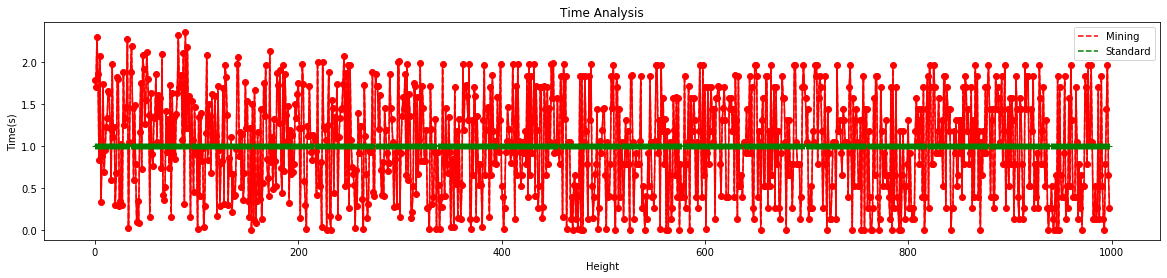

In [22]:
visualization(blocks)

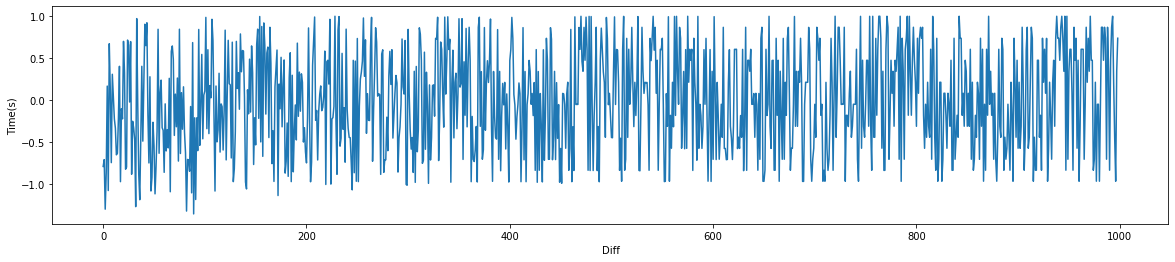

In [23]:
visualization2(errors)

In [149]:
from datetime import datetime
import time
start_time = datetime.now()
time.sleep(2)
end_time = datetime.now()
a = end_time - start_time
a.total_seconds()

2.005374

In [150]:
from multiprocessing import Process, Pool
import os

def run_proc(name):
    print('Run child process %s (%s)...' % (name, os.getpid()))
    
print('Parent process %s.' % os.getpid())
p = Process(target=run_proc, args=('test',))
print('Child process will start.')
p.start()
p.join()
print('Child process end.')

Parent process 6145.
Child process will start.
Child process end.


In [67]:
from multiprocessing import Pool
import os, time, random

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(random.random() * 3)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, (end - start)))

print('Parent process %s.' % os.getpid())
p = Pool(8)
for i in range(8):
    p.apply_async(long_time_task, args=(i,))
print('Waiting for all subprocesses done...')
p.close()
p.join()

print('All subprocesses done.')

Parent process 6145.
Run task 2 (11449)...
Run task 0 (11447)...
Run task 3 (11450)...
Run task 1 (11448)...
Run task 4 (11451)...
Run task 6 (11453)...
Run task 5 (11452)...
Run task 7 (11454)...
Task 6 runs 0.07 seconds.
Waiting for all subprocesses done...
Task 2 runs 0.50 seconds.
Task 5 runs 0.57 seconds.
Task 3 runs 0.62 seconds.
Task 0 runs 0.87 seconds.
Task 1 runs 1.03 seconds.
Task 7 runs 2.76 seconds.
Task 4 runs 3.00 seconds.
All subprocesses done.


In [11]:
from multiprocessing import Process, Queue
import os, time, random

# 写数据进程执行的代码:
def write(q):
    print('Process to write: %s' % os.getpid())
    for value in ['A', 'B', 'C']:
        print('Put %s to queue...' % value)
        q.put(value)
        time.sleep(random.random())

# 读数据进程执行的代码:
def read(q):
    print('Process to read: %s' % os.getpid())
    while True:
        value = q.get(True)
        print('Get %s from queue.' % value)

# 父进程创建Queue，并传给各个子进程：
q = Queue()
pw = Process(target=write, args=(q,))
pr = Process(target=read, args=(q,))
# 启动子进程pw，写入:
pw.start()
# 启动子进程pr，读取:
pr.start()
# 等待pw结束:
pw.join()
# pr进程里是死循环，无法等待其结束，只能强行终止:
pr.terminate()

Process to write: 12493
Put A to queue...
Process to read: 12494
Get A from queue.
Put B to queue...
Get B from queue.
Put C to queue...
Get C from queue.


In [42]:
from multiprocessing import Pipe, Process

def worker(conn):
    print(conn.recv())
    conn.send("sent from child process")

conn1, conn2 = Pipe()
process = Process(target=worker, args=[conn2])
process.start()

conn1.send("sent from main process")
print(conn1.recv())


sent from main process
sent from child process


In [47]:
import sys
print(sys.maxsize)

9223372036854775807


In [10]:
import math
math.log2(8)

3.0

In [42]:
print(os.cpu_count())

16


In [110]:
from datetime import datetime
t_merkle = 'fc8a1f655608fd9506559af832554f111e13821c'
t_height = 0
t_pre_hash = ""
t_nounce = 0
t_pre = '0'
t_start_time = datetime.now()

for x in range(0,1000000):
    block = Block(t_height, t_pre, t_merkle, x, [])
    t_height += 1
    t_pre = block.getHash()

t_end_time = datetime.now()
t_duration = t_end_time - t_start_time
t_duration = t_duration.total_seconds()
print('duration time: %s' % t_duration)


duration time: 2.751718


In [126]:
3458764513820541015 % 461168601842738 * 2.7/1000000

0.0162405